This model should not be utilized. It is kept her for the excercise. The kmeans clustering notebook is what should be utilized
- by Ricky Oropeza

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import matplotlib.dates as mdates
from datetime import date
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

In [2]:
df = pd.read_csv('../listings_mar7_2023.csv')
df = df[df['host_name'] != "Jino & Scott"]
df = df[df['host_name'] != "Scott And Jino"]
df['hotspot_from_listings'] = 0
df['hotspot_from_reviews'] = 0
df['hotspot_from_reviews_per_month'] = 0


In [3]:
#data cleaning. Price data has $ sign. The following code extracts the number
df['price'] = df['price'].replace({r'\$':''},regex = True).replace({r',':''},regex = True).astype('float')
df.price

0         399.0
1          46.0
2         408.0
3          80.0
4        2138.0
          ...  
42446      40.0
42447      48.0
42448      46.0
42449      68.0
42450      48.0
Name: price, Length: 40785, dtype: float64

In [4]:
print(df['room_type'].value_counts())

Entire home/apt    29489
Private room       10516
Shared room          697
Hotel room            83
Name: room_type, dtype: int64


In [5]:
df_practice = df.copy()
df_practice['name'] = df_practice['name'].str.lower()
df_practice.loc[df_practice['name'].str.contains('motel',regex=False) == True, 'room_type'] = 'Hotel room'
df_practice.loc[df_practice['name'].str.contains('hotel',regex=False) == True, 'room_type'] = 'Hotel room'
df['room_type'] = df_practice['room_type']
#df_practice.dropna()

In [6]:
print(df['room_type'].value_counts())

Entire home/apt    29291
Private room       10387
Shared room          696
Hotel room           411
Name: room_type, dtype: int64


In [7]:
df.price.max()

99999.0

In [8]:
df = df[df['price'] < 1999]

In [9]:
df.price.max()

1995.0

In [10]:
def get_listings_in_bin(df, lat_bin_num, long_bin_num, lats_bins_represent, longs_bins_represent):
    cond_gt_lats = df['latitude'] > lats_bins_represent[lat_bin_num]
    cond_lt_lats = df['latitude'] <= lats_bins_represent[lat_bin_num+1]
    cond_gt_long = df['longitude'] > longs_bins_represent[long_bin_num]
    cond_lt_long = df['longitude'] <= longs_bins_represent[long_bin_num+1]
    cut_df = df[cond_lt_lats & cond_gt_lats & cond_lt_long & cond_gt_long].copy()
    return cut_df

In [11]:
def calc_hotspot_by_roomtype(df,mile_per_bin):
    df_priv = df[df['room_type']=='Private room'].copy()
    df_homeapt = df[df['room_type']=='Entire home/apt'].copy()
    df_share = df[df['room_type']=='Shared room'].copy()
    df_hotel = df[df['room_type']=='Hotel room'].copy()

    #https://www.usgs.gov/faqs/how-much-distance-does-a-degree-minute-and-second-cover-your-maps
    #One degree of latitude equals approximately 364,000 feet (69 miles), one minute equals 6,068 feet (1.15 miles), and one-second equals 101 feet. 
    ratio_miles_to_onelat = 69
    desired_lat_mile_per_bin = mile_per_bin #i want each bin to represent x miles
    
     #One-degree of longitude equals 288,200 feet (54.6 miles), one minute equals 4,800 feet (0.91 mile), and one second equals 80 feet.
    ratio_miles_to_onelong = 54.6
    desired_long_mile_per_bin = mile_per_bin #i want each bin to represent x miles
    
    for df_roomtype in df_priv,df_homeapt,df_share,df_hotel:
        print(f"Range of latitude: {df_roomtype['latitude'].min()} to {df_roomtype['latitude'].max()}")
        print(f"Range of longitude: {df_roomtype['longitude'].min()} to {df_roomtype['longitude'].max()}")


        diff_in_lats = df_roomtype['latitude'].max() - df_roomtype['latitude'].min()
        diff_in_lats_in_miles = diff_in_lats*ratio_miles_to_onelat
        bins_lats = int(np.round(diff_in_lats_in_miles/desired_lat_mile_per_bin))
        print(f"Num of bins for latitude: {bins_lats}")

        diff_in_long = np.abs(df_roomtype['longitude'].max() - df_roomtype['longitude'].min())
        diff_in_long_in_miles = diff_in_long*ratio_miles_to_onelong
        bins_long = int(np.round(diff_in_long_in_miles/desired_long_mile_per_bin))
        print(f"Num of bins for longitude: {bins_long}")

        lats_bins_represent = np.linspace(df_roomtype['latitude'].min(),df_roomtype['latitude'].max(),bins_lats+1)
        longs_bins_represent = np.linspace(df_roomtype['longitude'].min(),df_roomtype['longitude'].max(),bins_long+1)

        H, xedges, yedges = np.histogram2d(df_roomtype['latitude'],df_roomtype['longitude'], bins=(bins_lats,bins_long) )
        H = H.T

        X, Y = np.meshgrid(xedges, yedges)

        min_max_scaled_H = H/np.max(H)

        num_of_reviews_in_bin = np.zeros(H.shape)
        num_of_reviews_per_month_in_bin = np.zeros(H.shape)
        
        for i in np.arange(0,H.shape[0],1):
            for j in np.arange(0,H.shape[1],1):
                dummy_df = get_listings_in_bin(df_hotel,j,i,lats_bins_represent,longs_bins_represent)
                num_of_reviews_in_bin[i,j] = dummy_df['number_of_reviews'].sum()
                num_of_reviews_per_month_in_bin[i,j] = dummy_df['reviews_per_month'].sum()

        min_max_scaled_reviews = num_of_reviews_in_bin/np.max(num_of_reviews_in_bin)
        min_max_scaled_reviews_per_month = num_of_reviews_per_month_in_bin/np.max(num_of_reviews_per_month_in_bin)               
        
        for longs in np.arange(0,H.shape[0],1):
            for lats in np.arange(0,H.shape[1],1):
                cond_gt_lats = df_roomtype['latitude'] > lats_bins_represent[lats]
                cond_lt_lats = df_roomtype['latitude'] <= lats_bins_represent[lats+1]
                cond_gt_long = df_roomtype['longitude'] > longs_bins_represent[longs]
                cond_lt_long = df_roomtype['longitude'] <= longs_bins_represent[longs+1]
                df_roomtype.loc[cond_lt_lats & cond_gt_lats & cond_lt_long & cond_gt_long, 'hotspot_from_listings'] = min_max_scaled_H[longs,lats]
                df_roomtype.loc[cond_lt_lats & cond_gt_lats & cond_lt_long & cond_gt_long, 'hotspot_from_reviews'] = min_max_scaled_reviews[longs,lats]
                df_roomtype.loc[cond_lt_lats & cond_gt_lats & cond_lt_long & cond_gt_long, 'hotspot_from_reviews_per_month'] = min_max_scaled_reviews_per_month[longs,lats]
        
    final_df = pd.concat([df_priv, df_homeapt, df_share, df_hotel], ignore_index=True,axis=0)
    return final_df
    



In [15]:
df_hot = calc_hotspot_by_roomtype(df,0.3)


Range of latitude: 33.33956 to 34.81113
Range of longitude: -118.89972464431123 to -117.6534
Num of bins for latitude: 338
Num of bins for longitude: 227
Range of latitude: 33.33848 to 34.79591
Range of longitude: -118.93483 to -117.66118
Num of bins for latitude: 335
Num of bins for longitude: 232
Range of latitude: 33.71559 to 34.64815
Range of longitude: -118.7056463 to -117.7491
Num of bins for latitude: 214
Num of bins for longitude: 174
Range of latitude: 33.76642 to 34.69972
Range of longitude: -118.64871978759766 to -117.85597
Num of bins for latitude: 215
Num of bins for longitude: 144


In [24]:
df_hot.to_csv('../listings_mar2023_w_hotspot_0.3milebins.csv')

In [12]:
df_priv = df[df['room_type']=='Private room'].copy()
df_homeapt = df[df['room_type']=='Entire home/apt'].copy()
df_share = df[df['room_type']=='Shared room'].copy()
df_hotel = df[df['room_type']=='Hotel room'].copy()

In [260]:
df_hotel['latitude'].min()

33.76642

In [21]:
print(f"Range of latitude: {df_priv['latitude'].min()} to {df_priv['latitude'].max()}")
print(f"Range of longitude: {df_priv['longitude'].min()} to {df_priv['longitude'].max()}")

#https://www.usgs.gov/faqs/how-much-distance-does-a-degee-minute-and-second-cover-your-maps
#One degree of latitude equals approximately 364,000 feet (69 miles), one minute equals 6,068 feet (1.15 miles), and one-second equals 101 feet. 
ratio_miles_to_onelat = 69
desired_lat_mile_per_bin = 1 #i want each bin to represent x miles
diff_in_lats = df_priv['latitude'].max() - df_priv['latitude'].min()
diff_in_lats_in_miles = diff_in_lats*ratio_miles_to_onelat
bins_lats = int(np.round(diff_in_lats_in_miles/desired_lat_mile_per_bin))
print(f"Num of bins for latitude: {bins_lats}")


#One-degree of longitude equals 288,200 feet (54.6 miles), one minute equals 4,800 feet (0.91 mile), and one second equals 80 feet.
ratio_miles_to_onelong = 54.6
desired_long_mile_per_bin = 1 #i want each bin to represent x miles
diff_in_long = np.abs(df_priv['longitude'].max() - df_priv['longitude'].min())
diff_in_long_in_miles = diff_in_long*ratio_miles_to_onelong
bins_long = int(np.round(diff_in_long_in_miles/desired_long_mile_per_bin))
print(f"Num of bins for longitude: {bins_long}")



Range of latitude: 33.33956 to 34.81113
Range of longitude: -118.89972464431123 to -117.6534
Num of bins for latitude: 102
Num of bins for longitude: 68


In [22]:
#you have to add 1 to the bins because the very 1st element in the list is exclusive 
lats_bins_represent = np.linspace(df_priv['latitude'].min(),df_priv['latitude'].max(),bins_lats+1)
longs_bins_represent = np.linspace(df_priv['longitude'].min(),df_priv['longitude'].max(),bins_long+1)

# print(lats_bins_represent)
# print(longs_bins_represent)

In [23]:
H, xedges, yedges = np.histogram2d(df_priv['latitude'],df_priv['longitude'], bins=(bins_lats,bins_long) )

H = H.T

#if i do 0.1 mile per bin for both lats and longs, there is a bright yellow spot. It may so dense that it could be an outlier and over shadow it
#if you want to see, run the lines below multiple times to remove the outliers and run the histogram plotting cell

#I did a further analysis on exploring why their was an outlier
#there is one airbnb host that has multiple accounts and they have over 1500 listings
#they rent rooms in mansions I think. Seems absurd to have 1500 bedrooms available to rent all at one time
#https://www.airbnb.com/users/401130632/listings
#https://www.airbnb.com/users/144214204/listings
#I think I will definitely ignore them for this as this is a huge outlier
#http://insideairbnb.com/los-angeles
#      If you go here and scroll, you will see jino & scott own the most listings for private rooms
# 
max_long_bin_num_priv = np.where(H == np.max(H))[0][0]
max_lat_bin_num_priv = np.where(H == np.max(H))[1][0]
print(H[max_long_bin_num_priv,max_lat_bin_num_priv])
H[max_long_bin_num_priv,max_lat_bin_num_priv] = 0 #when bins are represent 1 mile, do this to remove the outlier 

153.0


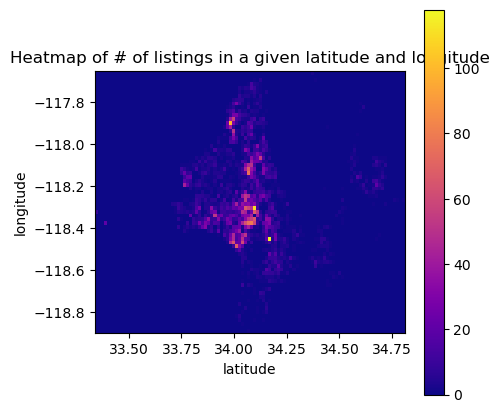

In [24]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(title='Heatmap of # of listings in a given latitude and longitude',
        aspect='equal')

X, Y = np.meshgrid(xedges, yedges)

hist2d = ax.pcolormesh(X, Y, H, cmap='plasma')
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
plt.colorbar(hist2d,ax=ax)
plt.show()

In [265]:
lats_bins_represent[max_lat_bin_num_priv],longs_bins_represent[max_long_bin_num_priv]

(34.05726232558139, -118.38997506525675)

In [266]:
def get_listings_in_bin(df, lat_bin_num, long_bin_num):
    cond_gt_lats = df['latitude'] > lats_bins_represent[lat_bin_num]
    cond_lt_lats = df['latitude'] <= lats_bins_represent[lat_bin_num+1]
    cond_gt_long = df['longitude'] > longs_bins_represent[long_bin_num]
    cond_lt_long = df['longitude'] <= longs_bins_represent[long_bin_num+1]
    cut_df = df[cond_lt_lats & cond_gt_lats & cond_lt_long & cond_gt_long].copy()
    return cut_df

In [267]:
potential_outlier_df_hotel = get_listings_in_bin(df_hotel,max_lat_bin_num_priv,max_long_bin_num_priv)
potential_outlier_df_hotel.shape

(72, 78)

In [268]:
potential_outlier_df_hotel.host_name.value_counts()

Michelle    14
April       12
Gabriela    10
Billy        9
Bobby        7
Scott        7
Fernanda     6
Dovid        6
Andre        1
Name: host_name, dtype: int64

In [269]:
df.host_name.value_counts()

Blueground    717
David         291
Alex          276
Michael       255
Nicole        234
             ... 
Joy Karen       1
Harmony         1
Hitmaker        1
Nav             1
Alyse           1
Name: host_name, Length: 7849, dtype: int64

In [35]:
min_max_scaled_H = H/np.max(H)

In [271]:
H.shape[1]

215

In [26]:
num_of_reviews_in_bin = np.zeros(H.shape)
for i in np.arange(0,H.shape[0],1):
    for j in np.arange(0,H.shape[1],1):
        dummy_df = get_listings_in_bin(df_hotel,j,i, lats_bins_represent,longs_bins_represent)
        num_of_reviews_in_bin[i,j] = dummy_df['number_of_reviews'].sum()

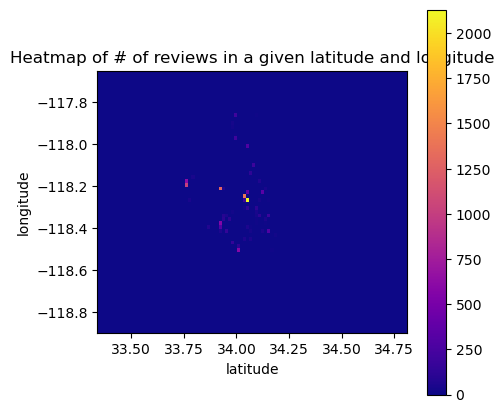

In [27]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(title='Heatmap of # of reviews in a given latitude and longitude',
        aspect='equal')

X, Y = np.meshgrid(xedges, yedges)

hist2d = ax.pcolormesh(X, Y, num_of_reviews_in_bin, cmap='plasma')
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
plt.colorbar(hist2d,ax=ax)
plt.show()

In [28]:
min_max_scaled_reviews = num_of_reviews_in_bin/np.max(num_of_reviews_in_bin)

In [30]:
min_max_scaled_reviews = num_of_reviews_in_bin/np.max(num_of_reviews_in_bin)
num_of_reviews_per_month_in_bin = np.zeros(H.shape)
for i in np.arange(0,H.shape[0],1):
    for j in np.arange(0,H.shape[1],1):
        dummy_df = get_listings_in_bin(df_hotel,j,i,lats_bins_represent,longs_bins_represent)
        num_of_reviews_per_month_in_bin[i,j] = dummy_df['reviews_per_month'].sum()

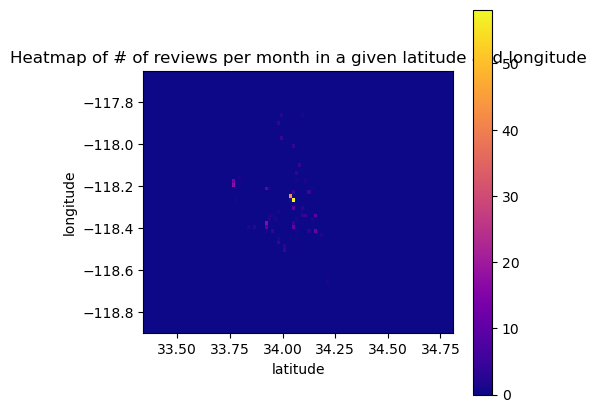

In [31]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(title='Heatmap of # of reviews per month in a given latitude and longitude',
        aspect='equal')

X, Y = np.meshgrid(xedges, yedges)

hist2d = ax.pcolormesh(X, Y, num_of_reviews_per_month_in_bin, cmap='plasma')
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
plt.colorbar(hist2d,ax=ax)
plt.show()

In [34]:
min_max_scaled_reviews_per_month = num_of_reviews_per_month_in_bin/np.max(num_of_reviews_per_month_in_bin)

In [32]:
df_hotel['hotspot_from_listings'] = 0
df_hotel['hotspot_from_reviews'] = 0
df_hotel['hotspot_from_reviews_per_month'] = 0


In [36]:
for longs in np.arange(0,H.shape[0],1):
    for lats in np.arange(0,H.shape[1],1):
        cond_gt_lats = df_hotel['latitude'] > lats_bins_represent[lats]
        cond_lt_lats = df_hotel['latitude'] <= lats_bins_represent[lats+1]
        cond_gt_long = df_hotel['longitude'] > longs_bins_represent[longs]
        cond_lt_long = df_hotel['longitude'] <= longs_bins_represent[longs+1]
        df_hotel.loc[cond_lt_lats & cond_gt_lats & cond_lt_long & cond_gt_long, 'hotspot_from_listings'] = min_max_scaled_H[longs,lats]
        df_hotel.loc[cond_lt_lats & cond_gt_lats & cond_lt_long & cond_gt_long, 'hotspot_from_reviews'] = min_max_scaled_reviews[longs,lats]
        df_hotel.loc[cond_lt_lats & cond_gt_lats & cond_lt_long & cond_gt_long, 'hotspot_from_reviews_per_month'] = min_max_scaled_reviews_per_month[longs,lats]


In [37]:
df_hotel['category_hotness_from_listings'] = round(df_hotel['hotspot_from_listings'],1)*10
df_hotel['category_hotness_from_reviews'] = round(df_hotel['hotspot_from_reviews'],1)*10
df_hotel['category_hotness_from_reviews_per_month'] = round(df_hotel['hotspot_from_reviews_per_month'],1)*10

Neural network below was just an excercise and isn't conclusive to anything.

In [39]:
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils.np_utils import to_categorical

In [40]:
## we first make an empty model
## Sequential means we'll make a group
## of a linear stack of layers
model = models.Sequential()

In [ ]:
###### ONLY RUN THIS ONCE! ##########

## you add a layer with .add()
## A Dense layer means a fully connected feedforward layer
## the 16 means the layer is 16 nodes tall
## activation='relu' means the layer uses a relu activation function
## the first layer needs to be told the shape of the input data
model.add(layers.Dense(16, activation = 'relu', input_shape=(2,)))

# we then add a second layer that is 16 nodes tall
# and uses the relu activation function
# note we don't need the input shape here, 
# it is inferred from the first layer's output
model.add(layers.Dense(16, activation = 'relu'))


# finally we add the output layer
# this will have a single node, representing a probability
# that the observation has positive sentiment
# this is why the activation is a softmax
# for more information on the softmax see the Practice Problems
model.add(layers.Dense(11, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                48        
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 11)                187       
                                                                 
Total params: 507
Trainable params: 507
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## we compile the network like so
## call .compile
## set our optimizer, optimizer='rmsprop'
## set our loss, loss='categorical_crossentropy'
## set our desired metrics, metrics=['accuracy']
model.compile(optimizer='rmsprop', 
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [ ]:
X = df_hotel[['latitude','longitude']]
y = df_hotel['category_hotness_from_listings']

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                       test_size=.2,
                                                       shuffle=True,
                                                       random_state=124,
                                                       stratify=y)

In [ ]:
X.shape

(28714, 2)

In [ ]:
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train,
                                                                 test_size=.2,
                                                                   shuffle=True,
                                                                   random_state=41,
                                                                   stratify=y_train)

In [ ]:
print(y_train_train)
print("\n\n\n")
print(to_categorical(y_train_train))
print(to_categorical(y_train_train).shape)
print(X_val.shape)

27647    0.0
12875    0.0
29618    1.0
23908    1.0
10350    0.0
        ... 
35516    0.0
22709    3.0
15538    0.0
10226    6.0
39198    5.0
Name: category_hotness_from_listings, Length: 18376, dtype: float64




[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(18376, 11)
(4595, 2)


In [ ]:
print(to_categorical(y_train_train).shape)
print(to_categorical(y_val).shape)
print(X_train_train.shape)
print(X_val.shape)

(18376, 11)
(4595, 11)
(18376, 2)
(4595, 2)


In [ ]:
## I now fit the model, and store the training history
## I use 100 epochs and a batch_size of 512
n_epochs = 100
batch_size = 512

history = model.fit(X_train_train, to_categorical(y_train_train),
                       epochs = n_epochs,
                       batch_size = batch_size,
                       validation_data = (X_val, to_categorical(y_val)))

Epoch 1/100
36/36 [==============================] - 1s 6ms/step - loss: 3.7142 - accuracy: 0.2839 - val_loss: 1.6445 - val_accuracy: 0.4755
Epoch 2/100
36/36 [==============================] - 0s 2ms/step - loss: 1.5639 - accuracy: 0.4756 - val_loss: 1.5154 - val_accuracy: 0.4755
Epoch 3/100
36/36 [==============================] - 0s 2ms/step - loss: 1.5141 - accuracy: 0.4685 - val_loss: 1.5058 - val_accuracy: 0.4755
Epoch 4/100
36/36 [==============================] - 0s 2ms/step - loss: 1.5125 - accuracy: 0.4746 - val_loss: 1.5246 - val_accuracy: 0.4755
Epoch 5/100
36/36 [==============================] - 0s 2ms/step - loss: 1.5118 - accuracy: 0.4744 - val_loss: 1.5102 - val_accuracy: 0.4755
Epoch 6/100
36/36 [==============================] - 0s 2ms/step - loss: 1.5113 - accuracy: 0.4756 - val_loss: 1.5150 - val_accuracy: 0.4755
Epoch 7/100
36/36 [==============================] - 0s 2ms/step - loss: 1.5108 - accuracy: 0.4756 - val_loss: 1.4988 - val_accuracy: 0.4755
Epoch 8/100
3

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


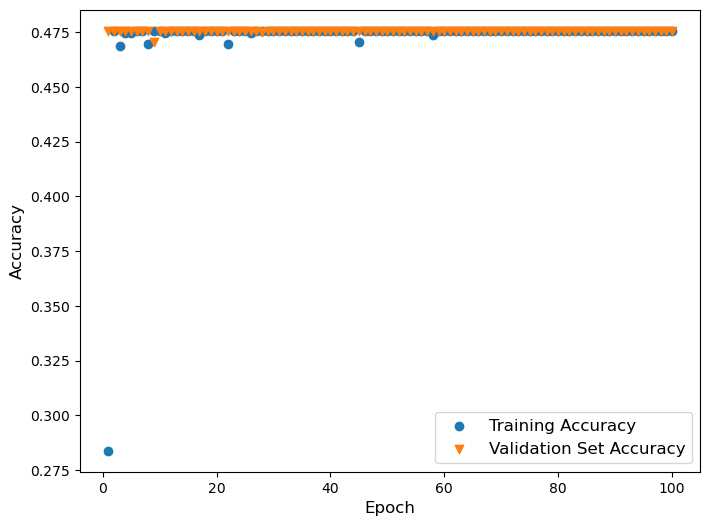

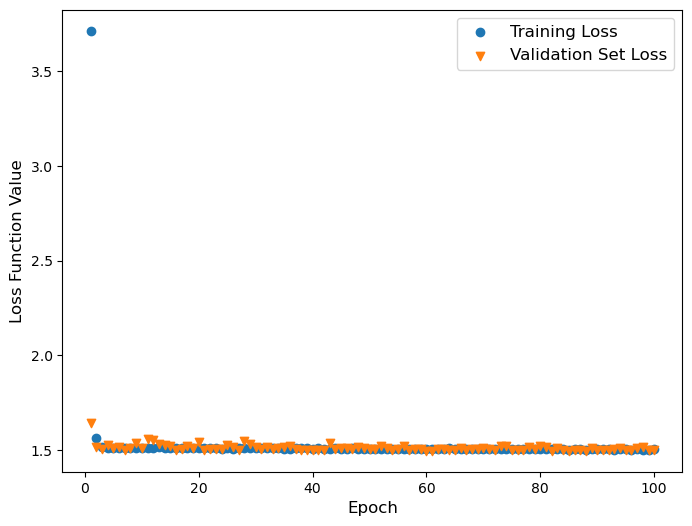

In [ ]:
plt.figure(figsize = (8,6))

plt.scatter(range(1,n_epochs+1), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,n_epochs+1), history_dict['val_accuracy'], marker='v', label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()


plt.figure(figsize = (8,6))

plt.scatter(range(1,n_epochs+1), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,n_epochs+1), history_dict['val_loss'], marker='v', label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Function Value", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

In [ ]:
#creates a map that has the shape of the united states

# fig = go.Figure(data=go.Scattergeo(
#         lon = df_hotel['longitude'],
#         lat = df_hotel['latitude'],
#         #text = 'Median house value: ' + housing['median_house_value'].astype(str),
#         #marker_size = (housing['bedrooms_per_household'])
#         ))
# fig.update_geos(fitbounds="locations")
# # fig.update_layout(
# #         title = 'Median house values of houses in California with marker size based on bedrooms per household',
# # )
# fig.show()

